In [1]:
import scanpy as sc

In [2]:
import scvi

Global seed set to 0


In [3]:
scvi.settings.seed = 0

Global seed set to 0


In [4]:
adata=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/APC_raw.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 128262 × 15777
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type'

In [6]:
adata.layers['raw_counts']=adata.X.copy()

In [7]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=1000,
    layer="raw_counts",
    batch_key="donor",
    span=1,
    subset=True,
)

In [8]:
adata

AnnData object with n_obs × n_vars = 128262 × 1000
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'sample_type'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'raw_counts'

In [9]:
scvi.model.SCVI.setup_anndata(adata, layer="raw_counts", batch_key='donor', categorical_covariate_keys=['tech'])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
model = scvi.model.SCVI(adata, n_hidden=120, n_layers=1, n_latent=10, gene_likelihood="zinb")


In [11]:
model.train()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H100 80GB HBM3') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 62/62: 100%|██████████| 62/62 [08:13<00:00,  4.42s/it, loss=437, v_num=1]

`Trainer.fit` stopped: `max_epochs=62` reached.


Epoch 62/62: 100%|██████████| 62/62 [08:13<00:00,  7.96s/it, loss=437, v_num=1]


In [12]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()


In [13]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)#, n_neighbors= 25)

In [14]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])

/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


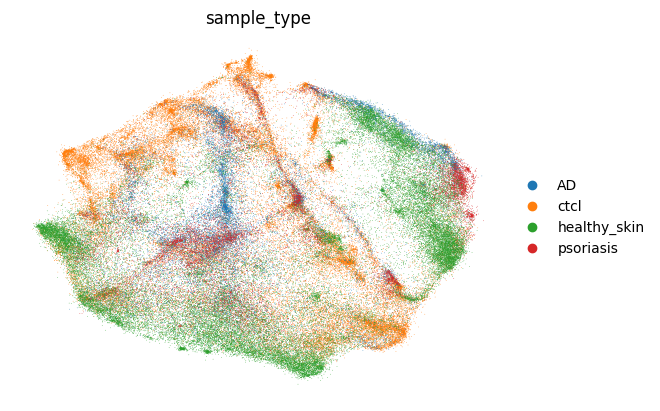

In [15]:
#SCVI_MDE_KEY = "X_scVI_MDE"
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["sample_type"],
    frameon=False,
    ncols=1,
)

In [16]:
adata2=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/APC_raw.h5ad')

In [17]:
adata2.obsm=adata.obsm
adata2.obsp=adata.obsp
adata2.uns=adata.uns

In [18]:
bc=adata2.obs.index.tolist()

In [19]:
annot=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects-new/all_samples_scvi_4kbydonor_6dim_100hidd_leiden_broad_ct_mastcell_corrected_celltypist.h5ad')

In [20]:
adata3=annot[bc, :].copy()

In [21]:
adata2.obs['cell_type']=adata3.obs['ctmajority_voting']

/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


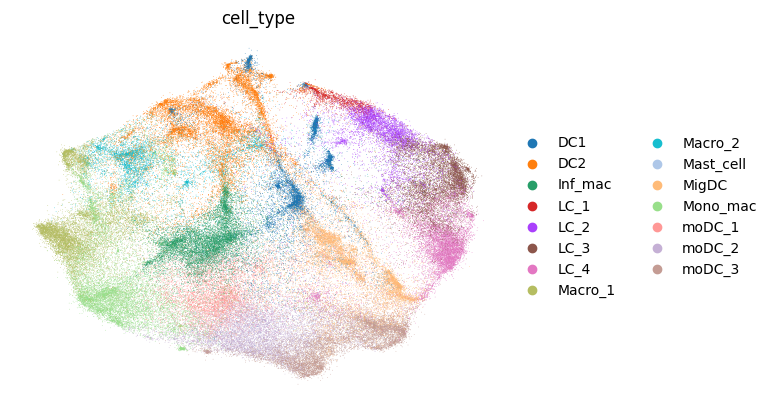

In [22]:
sc.pl.embedding(
    adata2,
    basis=SCVI_MDE_KEY,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

In [23]:
apc2=sc.read('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/APC_1k_bydonor_100hidd_5Dim_tech_cov_25_6_celltypist_transfer_from_main_pDC.h5ad')

In [24]:
adata2.obs['cell_type']=apc2.obs['cell_type']

/nfs/team298/ab72/miniconda3/envs/scvi3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


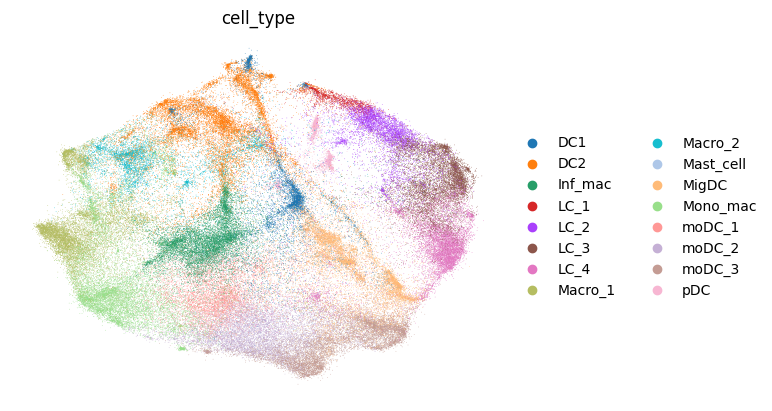

In [25]:
sc.pl.embedding(
    adata2,
    basis=SCVI_MDE_KEY,
    color=["cell_type"],
    frameon=False,
    ncols=1,
)

In [26]:
adata2.write_h5ad('/lustre/scratch126/cellgen/team298/ab72/CTCL/objects/APC_1k_default_tech_cov_27_6.h5ad')